# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, nbinom
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import os

# Importing Dataset

In [3]:
df = pd.read_csv("../data/processed/hierarchical_1min_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
features_col = [col for col in df.columns if col not in ["timestamp", "trade_count"]]
print(features_col)

['lag1_abs_log_return', 'lag1_trade_count', 'lag1_log_volume', 'lag1_buy_sell_imbalance', 'volatility']


# Hierarchical Trade Model

In [9]:
class HierarchicalTradeModel:
    def __init__(self, data: pd.DataFrame, features: list, target: str = 'trade_count'):
        if 'timestamp' not in data.columns:
            raise ValueError("Input data must contain a 'timestamp' column.")
        self.data = data.copy()
        self.features = features
        self.target = target
        self.params = None
        self._prepare_data()

    def _prepare_data(self):
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
        self.data['hour'] = self.data['timestamp'].dt.hour
        self.y = self.data[self.target].values
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.data[self.features].values)
        self.n_obs, self.n_features = self.X.shape
        self.n_hours = 24
        self.hour_indices = {h: np.where(self.data['hour'] == h)[0] for h in range(self.n_hours)}

    def _log_likelihood(self, y, mu, phi):
        mu = np.maximum(mu, 1e-9)
        phi = np.maximum(phi, 1e-9)
        n = phi
        p = phi / (phi + mu)
        return np.sum(nbinom.logpmf(y, n=n, p=p))

    def _log_priors(self, alphas, betas, phi, mu_alpha, sigma_alpha):
        log_p = 0
        log_p += np.sum(norm.logpdf(alphas, loc=mu_alpha, scale=sigma_alpha))
        log_p += np.sum(norm.logpdf(betas, loc=0, scale=10))
        log_p += expon.logpdf(phi, scale=1)
        log_p += norm.logpdf(mu_alpha, loc=0, scale=10)
        log_p += expon.logpdf(sigma_alpha, scale=1)
        return log_p

    def compute_posterior(self, n_samples: int, burn_in: int, proposal_widths: dict):
        params_current = {
            'alphas': np.zeros(self.n_hours), 'betas': np.zeros(self.n_features),
            'phi': 1.0, 'mu_alpha': 0.0, 'sigma_alpha': 1.0
        }
        samples = {key: [] for key in params_current}
        print("Starting MCMC sampling...")
        for i in tqdm(range(n_samples + burn_in)):
            for j in range(self.n_features):
                params_current['betas'][j], _ = self._metropolis_step(
                    'betas', j, params_current, proposal_widths.get('betas', 0.1))
            for h in range(self.n_hours):
                params_current['alphas'][h], _ = self._metropolis_step(
                    'alphas', h, params_current, proposal_widths.get('alphas', 0.1))
            params_current['phi'], _ = self._metropolis_step(
                'phi', None, params_current, proposal_widths.get('phi', 0.1))
            params_current['mu_alpha'], _ = self._metropolis_step(
                'mu_alpha', None, params_current, proposal_widths.get('mu_alpha', 0.1))
            params_current['sigma_alpha'], _ = self._metropolis_step(
                'sigma_alpha', None, params_current, proposal_widths.get('sigma_alpha', 0.1))
            if i >= burn_in:
                for key, value in params_current.items():
                    samples[key].append(np.copy(value))
        self.params = {key: np.array(value) for key, value in samples.items()}

    def _metropolis_step(self, param_name, param_index, params_current, proposal_width):
        params_proposal = {k: np.copy(v) for k, v in params_current.items()}
        current_value = params_current[param_name] if param_index is None else params_current[param_name][param_index]
        proposal = current_value + norm.rvs(scale=proposal_width)
        if param_name in ['phi', 'sigma_alpha'] and proposal <= 0: return current_value, 0
        if param_index is None: params_proposal[param_name] = proposal
        else: params_proposal[param_name][param_index] = proposal
        log_post_current = self._calculate_log_posterior(params_current)
        log_post_proposal = self._calculate_log_posterior(params_proposal)
        if np.log(np.random.rand()) < log_post_proposal - log_post_current:
            return proposal, 1
        else:
            return current_value, 0

    def _calculate_log_posterior(self, params):
        alphas, betas, phi = params['alphas'], params['betas'], params['phi']
        mu_alpha, sigma_alpha = params['mu_alpha'], params['sigma_alpha']
        log_mu = self.X @ betas
        for h in range(self.n_hours):
            log_mu[self.hour_indices[h]] += alphas[h]
        mu = np.exp(log_mu)
        return self._log_likelihood(self.y, mu, phi) + self._log_priors(alphas, betas, phi, mu_alpha, sigma_alpha)

    def _generate_posterior_predictive_samples(self):
        if self.params is None:
            raise RuntimeError("Posterior has not been computed. Please run compute_posterior() first.")

        num_posterior_samples = len(self.params['phi'])
        y_pred_samples = np.zeros((num_posterior_samples, self.n_obs))

        for i in tqdm(range(num_posterior_samples), desc="Generating predictive samples"):
            alphas_i = self.params['alphas'][i]
            betas_i = self.params['betas'][i]
            phi_i = np.maximum(self.params['phi'][i], 1e-9)
            
            log_mu_i = self.X @ betas_i + alphas_i[self.data['hour'].values]
            mu_i = np.exp(log_mu_i)
            mu_i = np.maximum(mu_i, 1e-9)

            n = phi_i
            p = phi_i / (phi_i + mu_i)
            
            y_pred_samples[i, :] = nbinom.rvs(n=n, p=p, size=self.n_obs)
            
        return y_pred_samples

    def calculate_posterior_predictive_coverage(self, credible_interval: float = 95.0):
        y_pred_samples = self._generate_posterior_predictive_samples()

        # Calculating lower and upper bounds for the credible interval
        lower_bound = np.percentile(y_pred_samples, (100 - credible_interval) / 2, axis=0)
        upper_bound = np.percentile(y_pred_samples, 100 - (100 - credible_interval) / 2, axis=0)
        
        # Checking which actual data points fall outside the interval
        outliers = (self.y < lower_bound) | (self.y > upper_bound)
        num_outliers = np.sum(outliers)
        
        coverage_percentage = (num_outliers / self.n_obs) * 100
        
        print("\n--- Posterior Predictive Coverage ---")
        print(f"Expected percentage of data outside {credible_interval}% credible interval: {100 - credible_interval:.2f}%")
        print(f"Actual percentage of data outside {credible_interval}% credible interval: {coverage_percentage:.2f}%")
        
        return coverage_percentage

    def plot_posterior_predictive(self, credible_interval: float = 95.0, sample_size: int = None):
        y_pred_samples = self._generate_posterior_predictive_samples()
        
        if sample_size is not None and sample_size < self.n_obs:
            plot_indices = np.linspace(0, self.n_obs - 1, sample_size, dtype=int)
        else:
            plot_indices = np.arange(self.n_obs)
    
        y_plot = self.y[plot_indices]
        timestamps_plot = self.data['timestamp'].iloc[plot_indices]
        y_pred_plot = y_pred_samples[:, plot_indices]
        
        mean_prediction = np.mean(y_pred_plot, axis=0)
        lower_bound = np.percentile(y_pred_plot, (100 - credible_interval) / 2, axis=0)
        upper_bound = np.percentile(y_pred_plot, 100 - (100 - credible_interval) / 2, axis=0)
    
        print("Plotting results...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(18, 8))
    
        ax.plot(timestamps_plot, y_plot, linestyle="--", color='darkorange', linewidth=1.5, 
                alpha=0.8, label='Actual Trade Count')
        
        ax.plot(timestamps_plot, mean_prediction, color='#003f5c', lw=2, label='Posterior Mean Prediction')
        ax.fill_between(timestamps_plot, lower_bound, upper_bound, color='#4f98ca', alpha=0.4, 
                        label=f'{credible_interval}% Predictive Interval')
        
        # Using a symmetric log scale to handle extreme outliers and zeros.
        ax.set_yscale('symlog', linthresh=1)
        
        ax.set_title('Posterior Predictive Check (Log Scale)', fontsize=18)
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Number of Trades per Minute (Log Scale)', fontsize=12)
        ax.legend(loc='upper left')
        
        ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')

        fig.autofmt_xdate()
        filename = f"Hierarchical_PPC.png"
        file_path = os.path.join("../figures/", filename)
        plt.savefig(file_path, format='png')
        plt.show()

# Posterior Predictive Check and Coverage

In [11]:
# features_to_use = ['log_volume', 'buy_sell_imbalance', 'volatility']
model = HierarchicalTradeModel(data=df, features=features_col, target='trade_count')

proposal_widths = {
    'betas': 0.05, 'alphas': 0.1, 'phi': 0.2,
    'mu_alpha': 0.1, 'sigma_alpha': 0.1
}
model.compute_posterior(n_samples=5000, burn_in=2000, proposal_widths=proposal_widths)

Starting MCMC sampling...


100%|██████████| 7000/7000 [04:56<00:00, 23.58it/s]


Generating predictive samples: 100%|██████████| 5000/5000 [00:03<00:00, 1385.11it/s]


Plotting results...


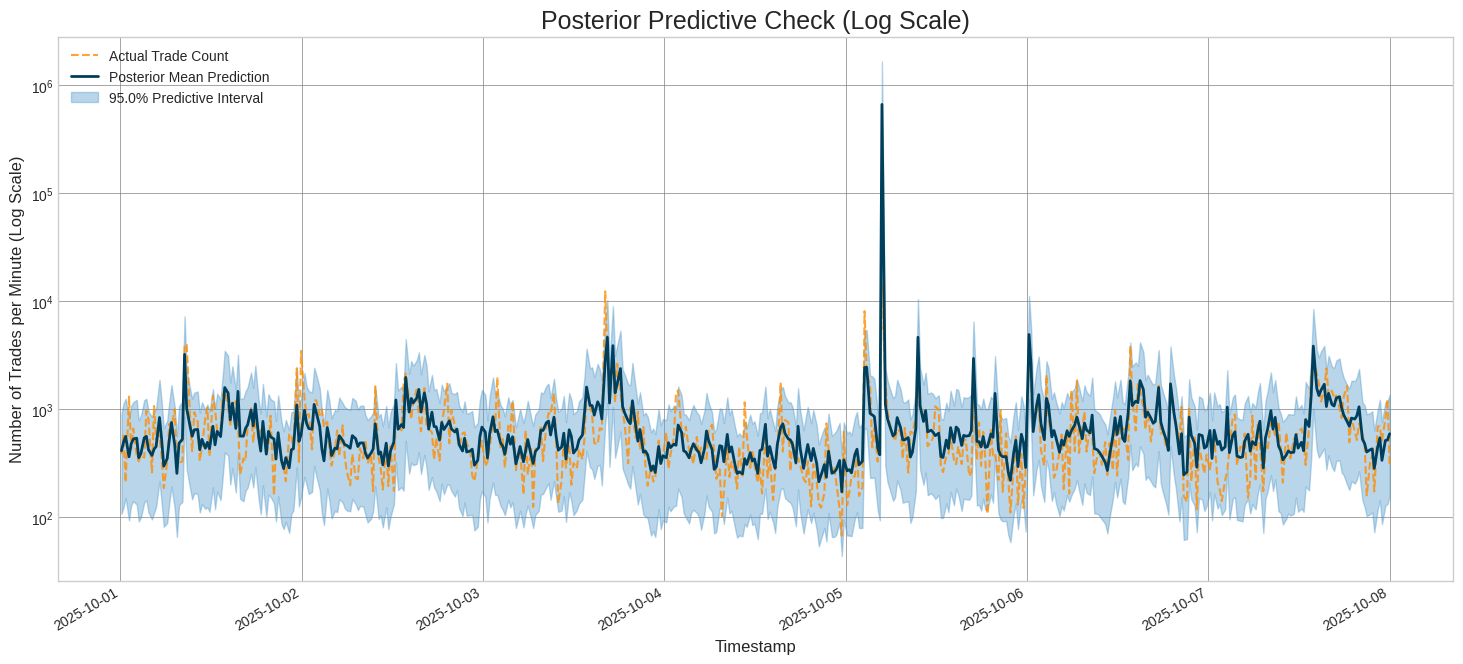

In [12]:
if model.params:
    model.plot_posterior_predictive(sample_size=500)

In [13]:
if model.params:
    model.calculate_posterior_predictive_coverage(credible_interval=95.0)

Generating predictive samples: 100%|██████████| 5000/5000 [00:03<00:00, 1336.55it/s]



--- Posterior Predictive Coverage ---
Expected percentage of data outside 95.0% credible interval: 5.00%
Actual percentage of data outside 95.0% credible interval: 4.13%
